<a href="https://colab.research.google.com/github/godlejr/PytorchSkeleton/blob/main/pytorch_json_seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

a = {'value1': 5, 'value2':10,'seq':[1,2,3,4,5]}

filename = 'test.json'

with open(filename,'w') as f:
    json.dump(a, f)

with open(filename,'r') as f:
    result = json.load(f)
    print(result)




{'value1': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [ ]:
!ls
!cat test.json

data  results  sample_data  test.json
{"value1": 5, "value2": 10, "seq": [1, 2, 3, 4, 5]}

In [ ]:
import hashlib

a = 'my name is kim'
hash_key = hashlib.sha1(a.encode()).hexdigest()[:6]
print(hash_key)


setting = {'value1': 5, 'value2':10,'seq':[1,2,3,4,5],'exp_name':'exp1'}
exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]

filename = '{}-{}.json'.format(exp_name, hash_key)

print(filename)




7c2951
exp1-4766aa.json


In [ ]:
!mkdir results
!ls

mkdir: cannot create directory ‘results’: File exists
data  results  sample_data  test.json


In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [ ]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 38.12/41.47, Loss(train/val) 2.44/1.72. Took 10.58 sec
Epoch 1, Acc(train/val): 46.07/37.54, Loss(train/val) 1.57/1.95. Took 10.62 sec
Epoch 2, Acc(train/val): 48.60/37.54, Loss(train/val) 1.49/1.90. Took 10.65 sec
Epoch 3, Acc(train/val): 51.31/45.06, Loss(train/val) 1.42/1.76. Took 10.64 sec
Epoch 4, Acc(train/val): 52.67/37.13, Loss(train/val) 1.38/2.31. Took 10.70 sec
Epoch 5, Acc(train/val): 55.37/45.89, Loss(train/val) 1.32/1.66. Took 10.69 sec
Epoch 6, Acc(train/val): 56.94/47.56, Loss(train/val) 1.28/1.64. Took 10.66 sec
Epoch 7, Acc(train/val): 58.65/41.77, Loss(train/val) 1.23/2.12. Took 10.62 sec
Epoch 8, Acc(train/val): 60.43/41.83, Loss(train/val) 1.20/2.24. Took 10.65 sec
Epoch 9, Acc(train/val): 61.81/44.87, Los

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


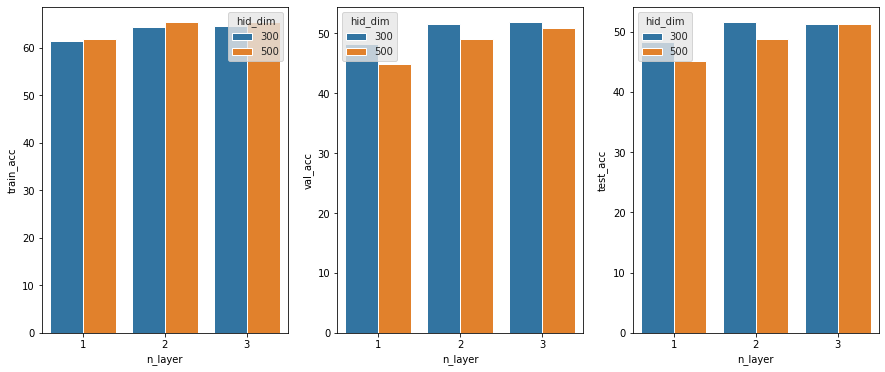

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

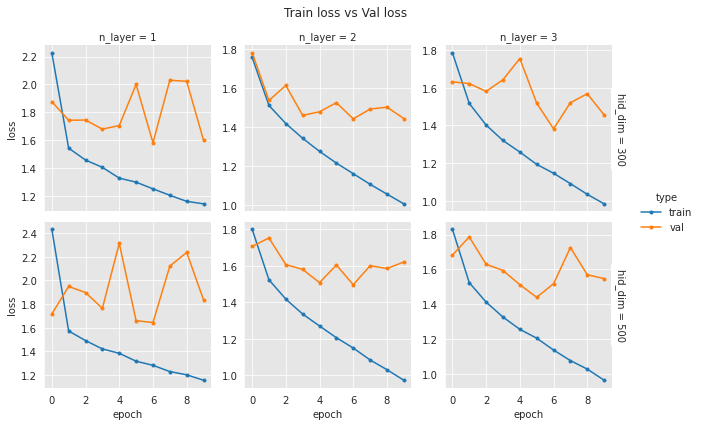

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

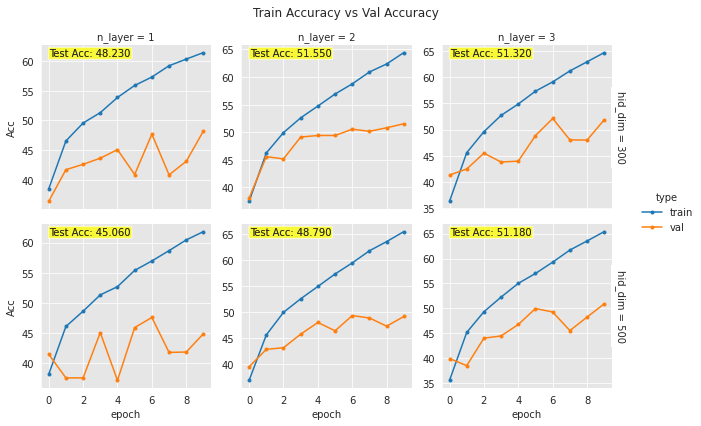

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [ ]:
!ls results
!cat results/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
{"train_losses": [1.7854763132751368, 1.5172864365729557, 1.4023919675000913, 1.3206211442400695, 1.259586309931081, 1.19417197878953, 1.1473254489291245, 1.092276889047805, 1.0357441397229576, 0.9853168589294337], "val_losses": [1.6312457919120789, 1.622060739994049, 1.5805181980133056, 1.6423774003982543, 1.754293429851532, 1.5186996936798096, 1.3823232173919677, 1.5207930326461792, 1.5681097388267518, 1.4560502409934997], "train_accs": [36.345, 45.5925, 49.5925, 52.695, 54.8575, 57.3025, 59.06, 61.1525, 62.8875, 64.6425], "val_accs": [41.35, 42.49, 45.5, 43.82, 43.99, 48.86, 52.1, 48.03, 48.0, 51.87], "train_acc": 64.6425, "val_acc": 51.87, "test_acc": 51.32, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true

In [ ]:
results = load_exp_result('exp1')

In [ ]:
results

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[2.435428700629313, 1.5721884935524812, 1.4911...","[1.7162062048912048, 1.9492196202278138, 1.898...","[38.125, 46.0675, 48.6025, 51.31, 52.6725, 55....","[41.47, 37.54, 37.54, 45.06, 37.13, 45.89, 47....",61.8100,44.87,45.06,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
1,"[1.8011471579788596, 1.523592875261975, 1.4178...","[1.7060554385185243, 1.7525290966033935, 1.606...","[36.915, 45.6025, 49.93, 52.5225, 54.885, 57.2...","[39.5, 42.85, 43.16, 45.75, 47.99, 46.4, 49.31...",65.3800,49.14,48.79,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
2,"[2.2276959373692797, 1.542182979310394, 1.4568...","[1.876650905609131, 1.7425587892532348, 1.7439...","[38.4175, 46.5325, 49.57, 51.3275, 53.895, 55....","[36.32, 41.67, 42.58, 43.62, 45.07, 40.86, 47....",61.4975,48.23,48.23,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
3,"[1.7567424599532109, 1.5103493503704193, 1.417...","[1.7803136348724364, 1.535821759700775, 1.6127...","[37.48, 46.2425, 49.935, 52.6075, 54.745, 56.9...","[38.07, 45.57, 45.17, 49.13, 49.41, 49.41, 50....",64.4375,51.54,51.55,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
4,"[1.8311871525588308, 1.5234525757990065, 1.411...","[1.6811469793319702, 1.7861740827560424, 1.629...","[35.62, 45.2075, 49.3475, 52.28, 55.03, 57.007...","[39.99, 38.56, 44.06, 44.51, 46.8, 49.99, 49.3...",65.3850,50.95,51.18,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
5,"[1.7854763132751368, 1.5172864365729557, 1.402...","[1.6312457919120789, 1.622060739994049, 1.5805...","[36.345, 45.5925, 49.5925, 52.695, 54.8575, 57...","[41.35, 42.49, 45.5, 43.82, 43.99, 48.86, 52.1...",64.6425,51.87,51.32,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3


In [ ]:
print(type(load_exp_result('exp1')))

a= [{'age':5, 'gender': 'f','score': 10,'t':1},
    {'age':28, 'gender': 'f','score': 20,'t':1},
    {'age':12, 'gender': 'f','score': 30,'t':1},
    {'age':22, 'gender': 'm','score': 40,'t':2},
    {'age':32, 'gender': 'f','score': 20,'t':2},
    {'age':15, 'gender': 'M','score': 60,'t':2}]

<class 'pandas.core.frame.DataFrame'>


In [ ]:
df = pd.DataFrame(a)
df

,age,gender,score
0,5,f,10
1,28,f,20
2,12,f,30
3,22,m,40
4,32,f,20
5,15,M,60


In [ ]:
!pip install seaborn==0.9.0

0.9.0


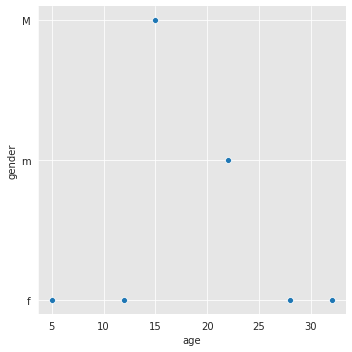

In [ ]:
import seaborn as sns
print(sns.__version__)

sns.relplot(x='age',y='gender', data=df)
sns.barplot(x='age',y='score',hue='gender' data=df)




In [ ]:
result = load_exp_result('exp1')
sns.barplot(x='n_layer',y='test_acc',hue='hid_dim' data=result)



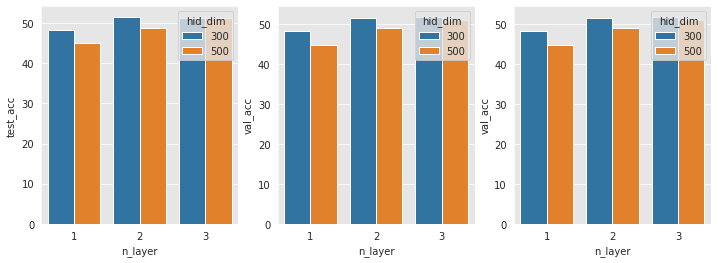

In [ ]:
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)
sns.barplot(x='n_layer',y='test_acc',hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer',y='val_acc',hue='hid_dim' ,data=df, ax=ax[1])
sns.barplot(x='n_layer',y='val_acc',hue='hid_dim' ,data=df, ax=ax[2])



In [ ]:

# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

# ====== Model Capacity ====== #
args.n_layer = 3 
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.001, 0.01, 0.1]
list_var2 = [0,1,0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=100, in_dim=3072, l2=1e-05, lr=0.001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 39.65/40.87, Loss(train/val) 1.69/1.65. Took 10.95 sec
Epoch 1, Acc(train/val): 47.47/44.08, Loss(train/val) 1.47/1.58. Took 10.92 sec
Epoch 2, Acc(train/val): 50.85/45.50, Loss(train/val) 1.38/1.56. Took 10.89 sec
Epoch 3, Acc(train/val): 53.63/46.94, Loss(train/val) 1.30/1.50. Took 10.91 sec
Epoch 4, Acc(train/val): 55.57/46.95, Loss(train/val) 1.24/1.54. Took 10.97 sec
Epoch 5, Acc(train/val): 57.43/47.61, Loss(train/val) 1.19/1.49. Took 10.86 sec
Epoch 6, Acc(train/val): 59.00/48.31, Loss(train/val) 1.15/1.49. Took 10.81 sec
Epoch 7, Acc(train/val): 60.59/48.39, Loss(train/val) 1.11/1.50. Took 11.05 sec
Epoch 8, Acc(train/val): 61.90/47.49, Loss(train/val) 1.07/1.58. Took 10.92 sec
Epoch 9, Acc(train/val): 63.32/49.53, Loss(train/